In [1]:
import anndata
import numpy as np
import pandas as pd
import seaborn as sns
import os

from scroutines.config_plots import *
from scroutines import basicu
import importlib
importlib.reload(basicu)

<module 'scroutines.basicu' from '/u/project/zipursky/f7xiesnm/code/scroutines/scroutines/basicu.py'>

# check features

In [2]:
# %%time
# f = "../data/cheng21_cell_scrna/organized/P14NR.h5ad" # 240208 - for some reason all_IT.h5ad takes too long to load for 10G
# adata = anndata.read(f)
# adata

In [5]:
ddir = '../../data/cheng21_cell_scrna/organized/'
files = [
     'P8NR.h5ad',
    'P14NR.h5ad',
    'P17NR.h5ad',
    
    'P21NR.h5ad',
    'P28NR.h5ad',
    'P38NR.h5ad',
] 

In [6]:
pbulks = []
xclsts = []
xcnsts = []

ncond, nrep, nclst, ngene = len(files), 2, 8, -1, 

for f in files:
    print(f)
    
    path = os.path.join(ddir, f)
    adata = anndata.read(path)
    genes = adata.var.index.values
    
    adata = adata[adata.obs['Class_broad'].str.contains('Excitatory')]
    mat = adata.X
    # type 
    types = adata.obs['Subclass'].astype(str).values
    
    # 1 or 2
    sample_codes = adata.obs['sample'].apply(lambda x: x.split('_')[-1][:-1].replace('3', '2')).astype(str).values
    sample_and_type = sample_codes + "_" + types
    unqs, cnts = np.unique(sample_and_type, return_counts=True)
    _xclsts, Xk, Xk_n, Xk_ln = basicu.counts_to_bulk_profiles(mat, sample_and_type) 
    
    # check all types + reps are the same
    if len(xclsts) > 0:
        if not np.all(_xclsts == xclsts):
            raise ValueError(_xclsts.shape, xclsts.shape, _xclsts, xclsts,)
        if not np.all(_xclsts == unqs):
            raise ValueError(_xclsts.shape, unqs.shape, _xclsts, unqs,)
    else:
        xclsts = _xclsts
        print(xclsts)
        
    print(Xk_ln.shape)
    pbulks.append(Xk_ln)
    xcnsts.append(cnts)
    
pbulks = np.array(pbulks)
xcnsts = np.array(xcnsts)
print(pbulks.shape)
pbulks = pbulks.reshape(ncond,nrep,nclst,-1)
xcnsts = xcnsts.reshape(ncond,nrep,nclst)
xclsts = xclsts.reshape(      nrep,nclst)
print(pbulks.shape)

P8NR.h5ad
['1_L2/3' '1_L4' '1_L5IT' '1_L5NP' '1_L5PT' '1_L6CT' '1_L6IT' '1_L6b'
 '2_L2/3' '2_L4' '2_L5IT' '2_L5NP' '2_L5PT' '2_L6CT' '2_L6IT' '2_L6b']
(16, 53801)
P14NR.h5ad
(16, 53801)
P17NR.h5ad
(16, 53801)
P21NR.h5ad
(16, 53801)
P28NR.h5ad
(16, 53801)
P38NR.h5ad
(16, 53801)
(6, 16, 53801)
(6, 2, 8, 53801)


In [7]:
# check the pbulks are good -- log10(CPM+1) for each sample
checkpbulks = np.sum(np.power(10, pbulks)-1, axis=-1)
checkpbulks.shape, np.all(np.abs(checkpbulks-1e6) < 1e-6)

((6, 2, 8), True)

In [8]:
# xclsts_short = np.array([clst[len("1a_"):] for clst in xclsts[0]]) #, '_'
xclsts_short = np.array([clst[len("1_"):] for clst in xclsts[0]]) #, '_'
xclsts_short, xclsts_short.shape

(array(['L2/3', 'L4', 'L5IT', 'L5NP', 'L5PT', 'L6CT', 'L6IT', 'L6b'],
       dtype='<U4'),
 (8,))

# filter out small bulk profiles

In [9]:
numcells = pd.DataFrame(xcnsts.T.reshape(-1,nrep*ncond), index=xclsts_short)
numcells.min(axis=1).sort_values()

L5IT      1
L5PT      1
L6b      28
L5NP     74
L6IT    243
L6CT    305
L2/3    720
L4      831
dtype: int64

In [10]:
xclsts_sel = xclsts_short[numcells.min(axis=1)>20]
unq_types = xclsts_sel
xclsts_selidx = basicu.get_index_from_array(xclsts_short, xclsts_sel)
pbulks = pbulks[:,:,xclsts_selidx,:]
xclsts_sel, xclsts_selidx, xclsts_sel.shape

(array(['L2/3', 'L4', 'L5NP', 'L6CT', 'L6IT', 'L6b'], dtype='<U4'),
 array([0, 1, 3, 5, 6, 7]),
 (6,))

In [11]:
# mean (across 2 rep) expr of CPM=10 in any subclass at any time
expressed_any = np.any(np.mean(pbulks, axis=2) > np.log10(10+1), axis=(0,1)) 
print(expressed_any.sum())

genes_comm = genes[expressed_any]
genes_cidx = np.arange(len(genes))[expressed_any] 
pbulks = pbulks[:,:,:,expressed_any]
print(pbulks.shape)


9963
(6, 2, 6, 9963)


In [12]:
nt, nr, nc, ng = pbulks.shape # ncond, nclst, nrep
nt, nr, nc, ng

(6, 2, 6, 9963)

In [13]:
def get_eta2_allgenes(nums):
    """
    nums: c1,c2,...,n matrix - ... conditions by n genes
    
    return (eta2, stdv) - vectors one entry for each gene
    """
    nc0, nc1, nc2, ng = nums.shape # (num time points, num rep, num genes)

    nums_m  = np.mean(nums, axis=(0,1,2)) #
    nums_m0 = np.mean(nums, axis=(1,2))   # 0
    nums_m1 = np.mean(nums, axis=(0,2))   # 0
    nums_m2 = np.mean(nums, axis=(0,1))   # 0
    

    # # SSt 
    diff = nums - np.expand_dims(nums_m , axis=(0,1,2))
    SSt  = np.sum(np.power(diff, 2), axis=(0,1,2))  # one for each gene

    # # SSw
    diff = nums - np.expand_dims(nums_m0, axis=(1,2))
    SSw0 = np.sum(np.power(diff, 2), axis=(0,1,2))  # one for each gene
    
    diff = nums - np.expand_dims(nums_m1, axis=(0,2))
    SSw1 = np.sum(np.power(diff, 2), axis=(0,1,2))  # one for each gene
    
    diff = nums - np.expand_dims(nums_m2, axis=(0,1))
    SSw2 = np.sum(np.power(diff, 2), axis=(0,1,2))  # one for each gene

    eta2_0 = (1-(SSw0+1e-6)/(SSt+1e-6))
    eta2_1 = (1-(SSw1+1e-6)/(SSt+1e-6))
    eta2_2 = (1-(SSw2+1e-6)/(SSt+1e-6))
    
    # stdb = np.sqrt((SSt-SSw)/(nt*nr))
    return eta2_0, eta2_1, eta2_2



In [14]:
eta2_t, eta2_r, eta2_c = get_eta2_allgenes(pbulks)

In [15]:
eta2_t.shape

(9963,)

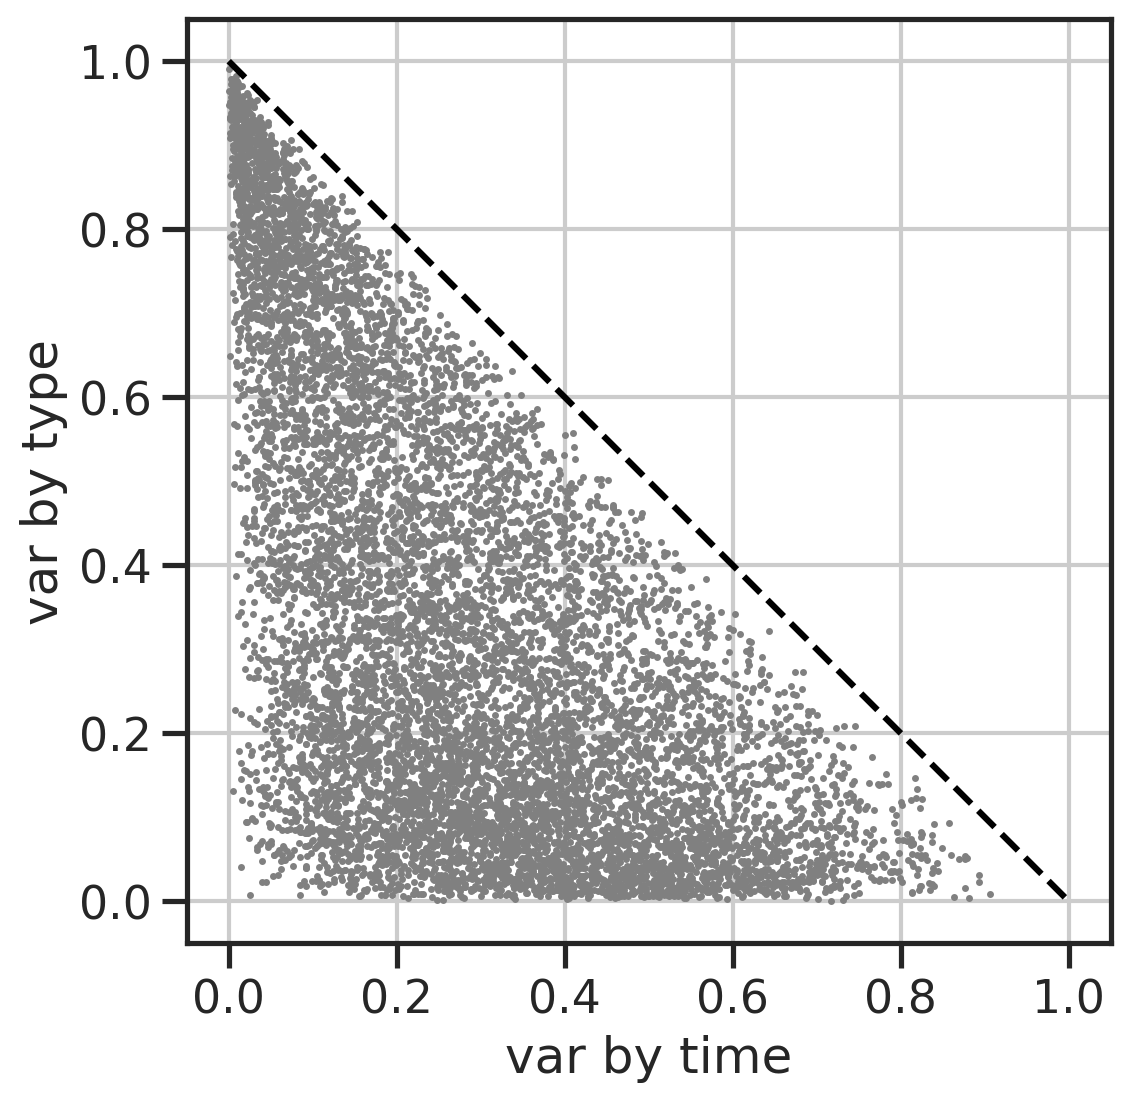

In [16]:
fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(eta2_t, eta2_c, s=1, color='gray')
ax.set_aspect('equal')
ax.set_xlabel('var by time')
ax.set_ylabel('var by type')
ax.plot([0,1], [1,0], color='k', linestyle='--')
plt.show()


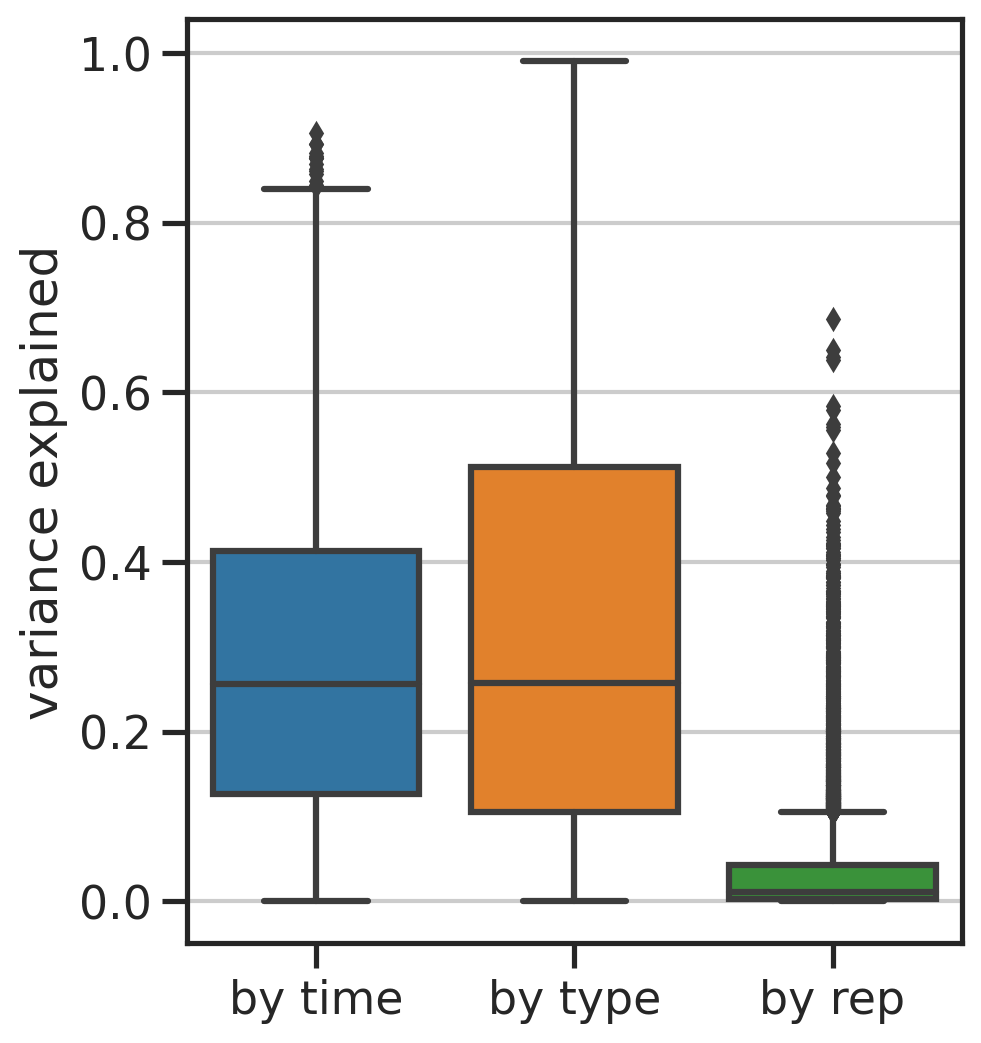

In [17]:
fig, ax = plt.subplots(figsize=(5,6))
sns.boxplot([eta2_t, eta2_c, eta2_r])
ax.set_xticklabels(['by time', 'by type', 'by rep'])
ax.set_ylabel('variance explained')
plt.show()

In [18]:
genes = adata.var.index.values[expressed_any]
genes.shape

(9963,)

In [19]:
types = xclsts_sel 
colors = sns.color_palette('tab10', len(types))
ts = [8, 14, 17, 21, 28, 38]
types, colors

(array(['L2/3', 'L4', 'L5NP', 'L6CT', 'L6IT', 'L6b'], dtype='<U4'),
 [(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
  (1.0, 0.4980392156862745, 0.054901960784313725),
  (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
  (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
  (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
  (0.5490196078431373, 0.33725490196078434, 0.29411764705882354)])

In [20]:
gi = np.argmax(eta2_t)
gi, genes[gi], eta2_t[gi], eta2_c[gi], eta2_r[gi], eta2_t[gi] + eta2_c[gi] + eta2_r[gi]

(6839,
 'Sept8',
 0.9061795403550201,
 0.008719031592417825,
 0.02983306282133269,
 0.9447316347687706)

In [21]:
gi = np.argmax(eta2_c)
gi, genes[gi], eta2_t[gi], eta2_c[gi], eta2_r[gi], eta2_t[gi] + eta2_c[gi] + eta2_r[gi]

(8238,
 'Cdh18',
 0.0006491585943718681,
 0.9902999276351448,
 5.3767032448859275e-05,
 0.9910028532619656)

In [22]:
gi_c = np.argsort(eta2_c)[::-1]
genes[gi_c]

array(['Cdh18', 'Rai14', 'Zfpm2', ..., 'Rps19', 'Gm42826', 'Gm36992'],
      dtype=object)

In [23]:
gi = gi_c[2]
pbulks_g = pbulks[:,:,:,gi]
pbulks_g = np.swapaxes(pbulks_g, 0, -1) # nt, nr, nc -> nc, nr, nt
gname = genes[gi]
print(pbulks_g.shape)

(6, 2, 6)


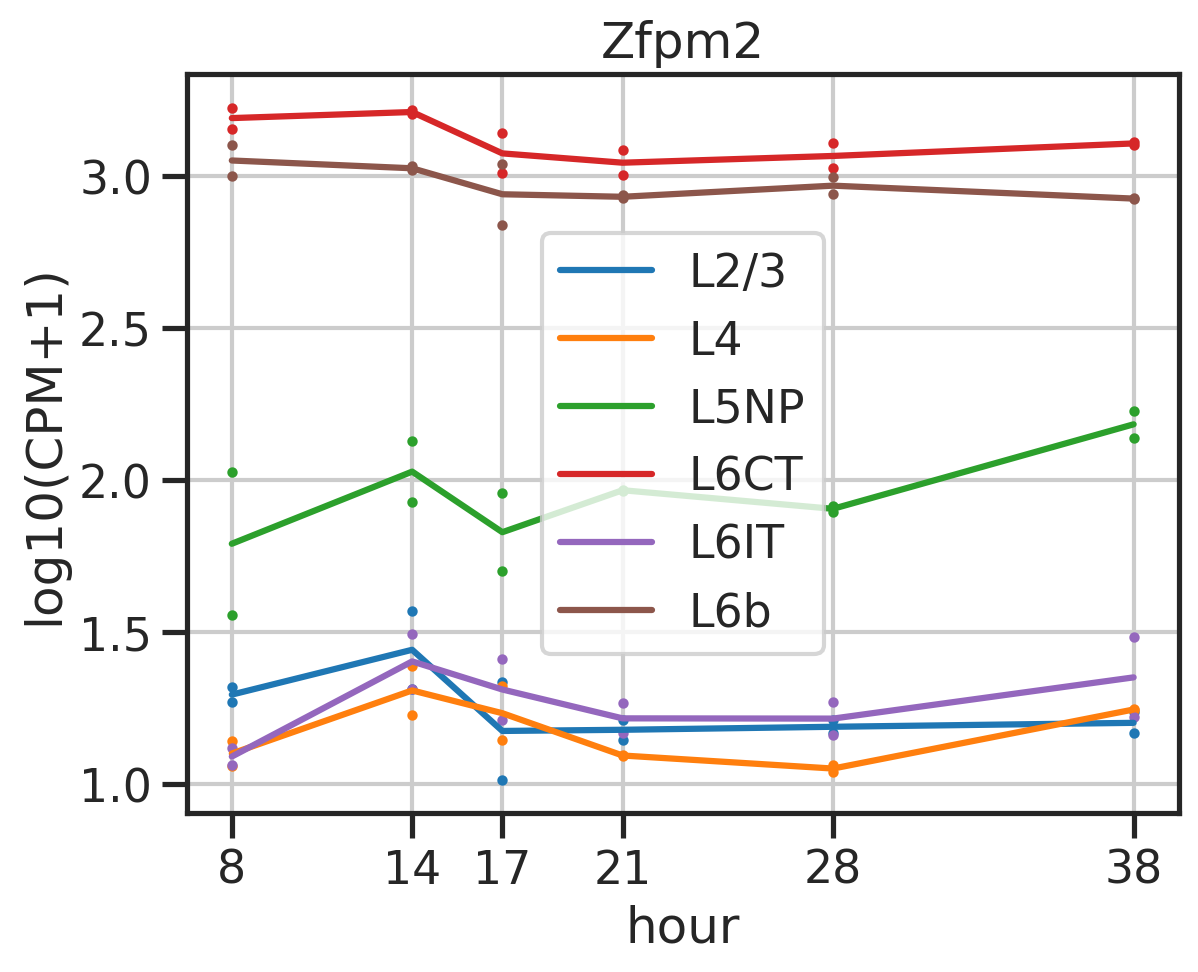

In [24]:
fig, ax = plt.subplots()
ax.set_title(gname)
for i in range(nc):
    color = colors[i]
    lbl = types[i]
    ax.plot(ts, np.mean(pbulks_g[i], axis=0), color=color, label=lbl)
    ax.scatter(ts, pbulks_g[i][0], s=5, color=color)
    ax.scatter(ts, pbulks_g[i][1], s=5, color=color)
ax.set_xticks(ts)
ax.legend()
ax.set_ylabel('log10(CPM+1)')
ax.set_xlabel('hour')
plt.show()

# top 10 type specific genes

In [25]:
gi_c = np.argsort(eta2_c)[::-1][:15]
gi_c

array([8238, 8224, 8290, 2437, 6042, 2848, 1072, 4564, 5085, 3530, 2849,
        582, 6420, 3684, 5150])

In [26]:
pbulks.shape

(6, 2, 6, 9963)

In [27]:
pbulks_sub = pbulks[:,:,:,gi_c]
print(pbulks_sub.shape)
pbulks_sub = np.swapaxes(pbulks_sub, 0, 3) # nt, nr, nc, ng -> ng, nc, nr, nt
print(pbulks_sub.shape)
pbulks_sub = np.swapaxes(pbulks_sub, 1, 2) # nt, nr, nc, ng -> ng, nc, nr, nt
gnames = genes[gi_c]
print(pbulks_sub.shape)

(6, 2, 6, 15)
(15, 2, 6, 6)
(15, 6, 2, 6)


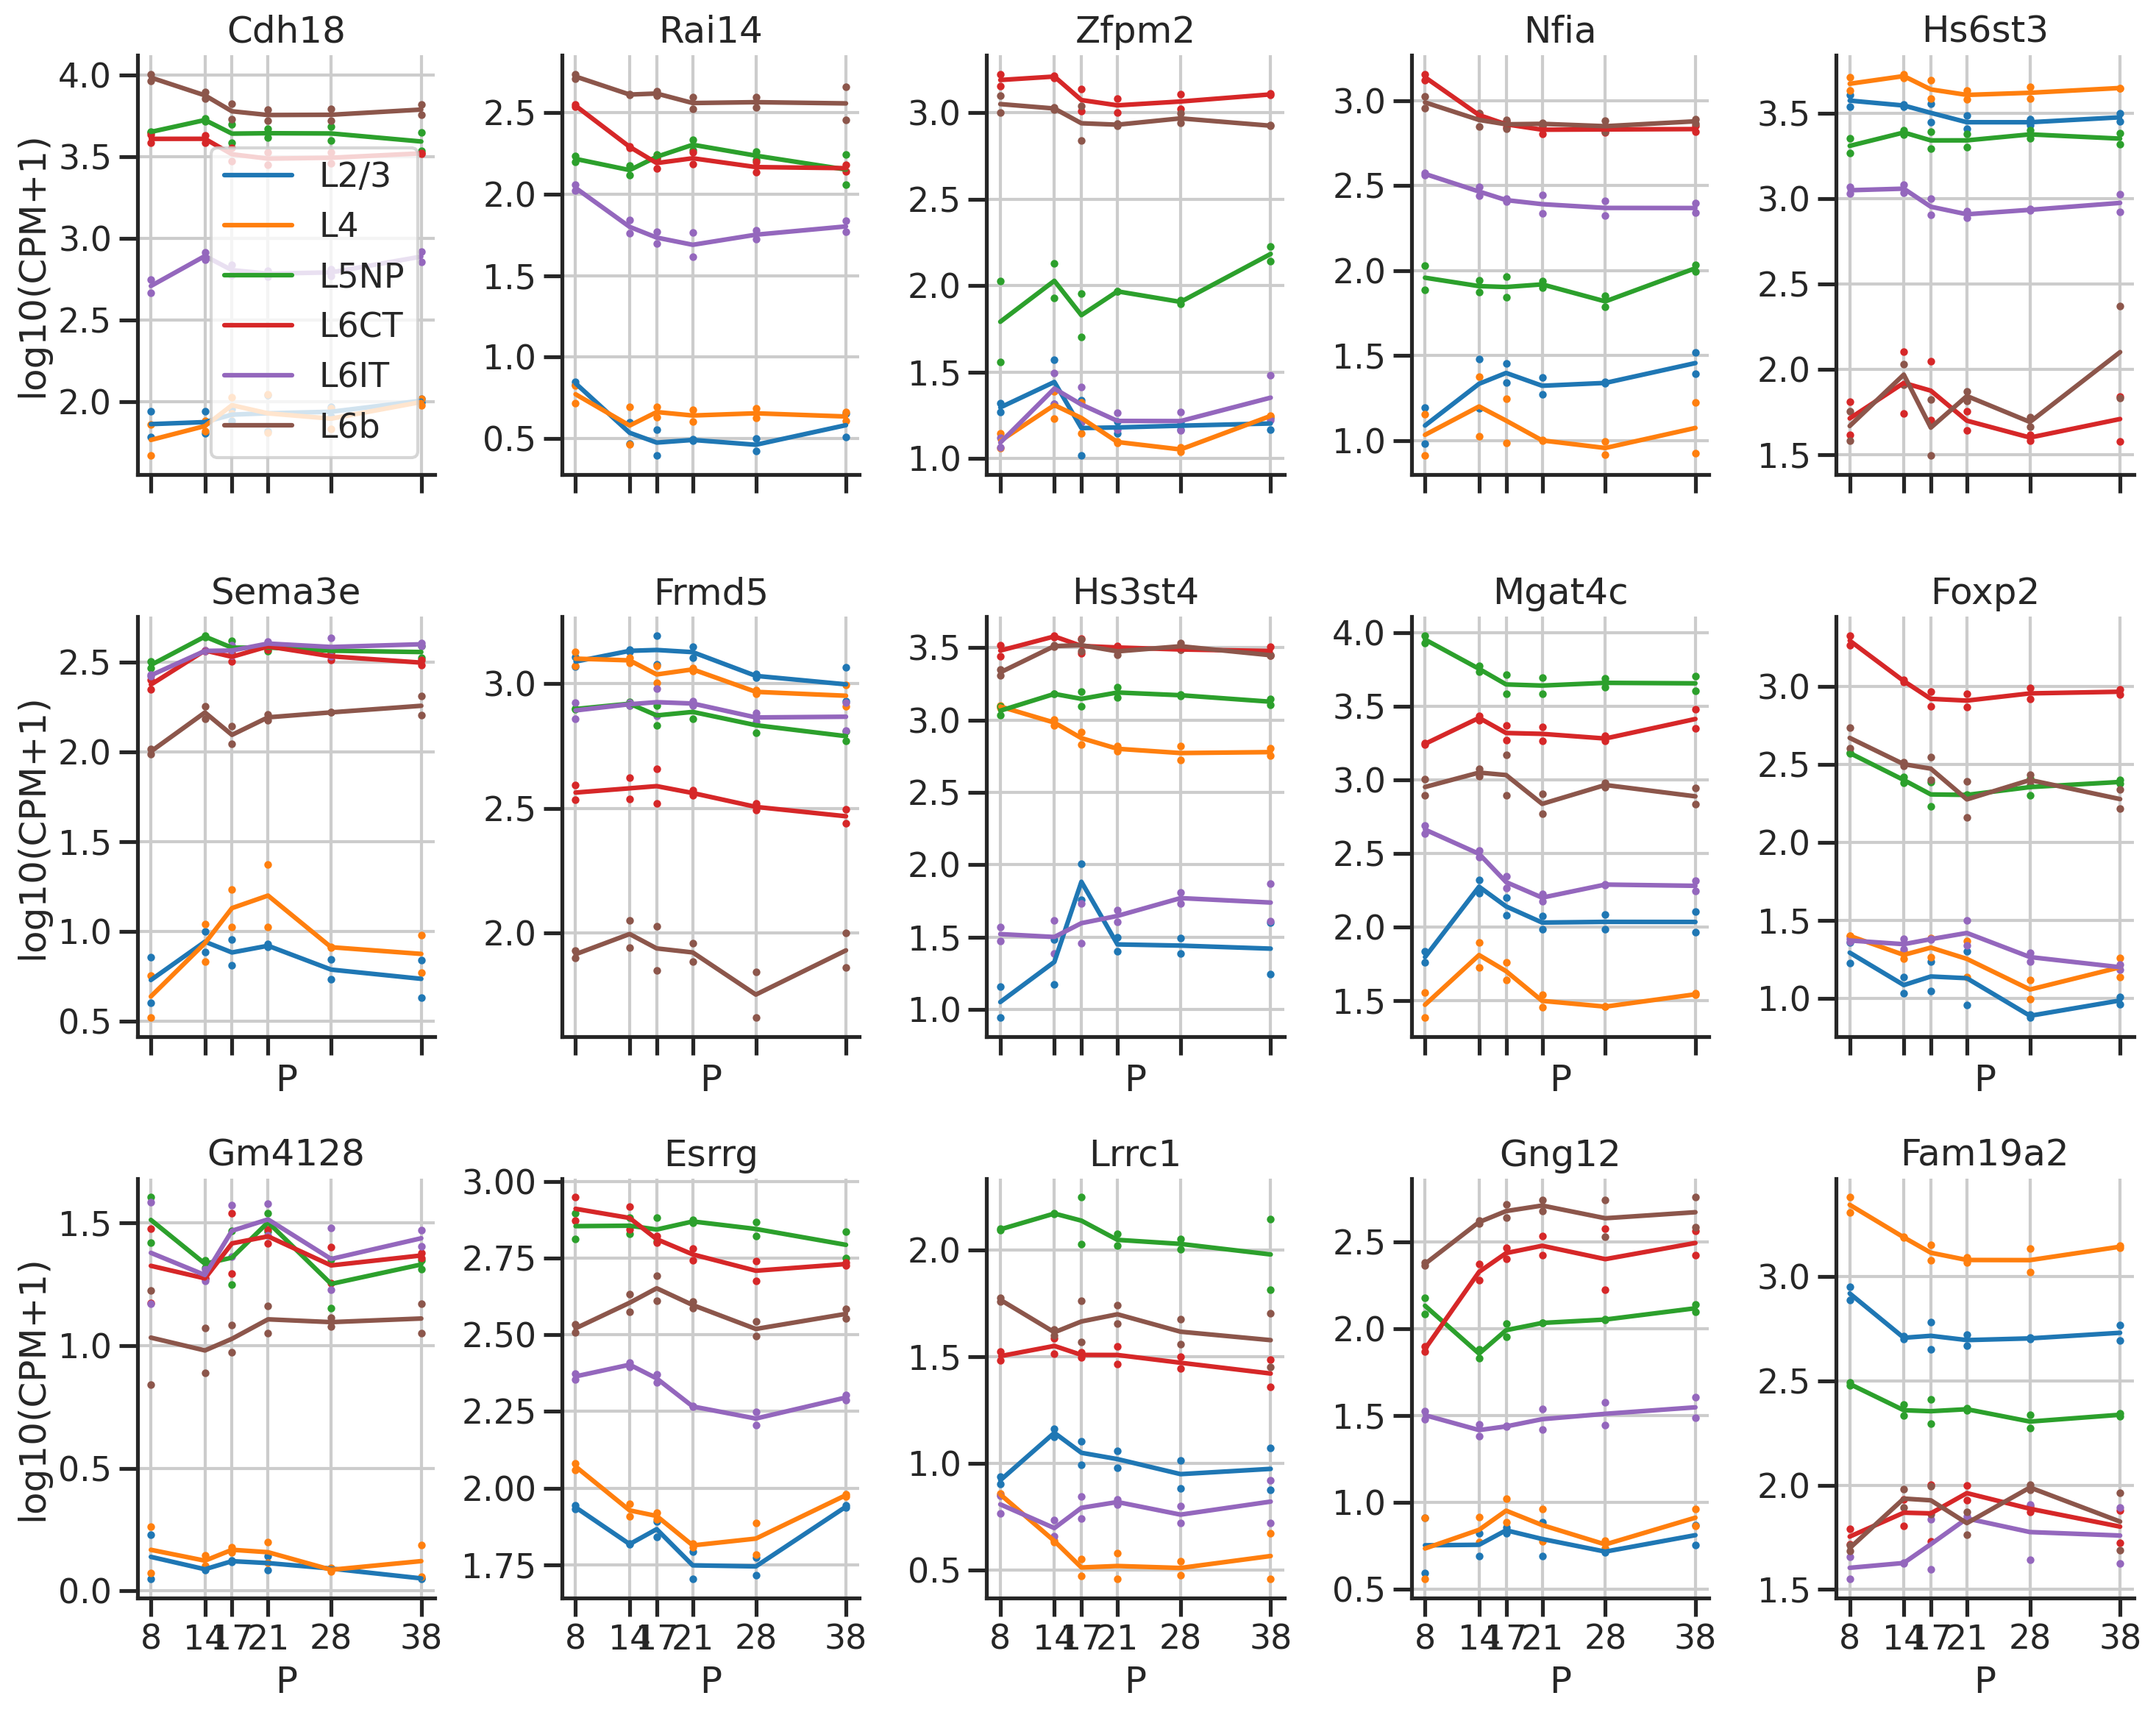

In [28]:
fig, axs = plt.subplots(3,5,figsize=(5*3,3*4), sharex=True)
for j, (pbulks_g, gname, ax) in enumerate(zip(pbulks_sub, gnames, axs.flat)):
    ax.set_title(gname)
    for i in range(nc):
        color = colors[i]
        lbl = types[i]
        ax.plot(ts, np.mean(pbulks_g[i], axis=0), color=color, label=lbl)
        ax.scatter(ts, pbulks_g[i][0], s=5, color=color)
        ax.scatter(ts, pbulks_g[i][1], s=5, color=color)
    ax.set_xticks(ts)
    sns.despine(ax=ax)
    if j == 0:
        ax.legend()
    if j % 5 == 0:
        ax.set_ylabel('log10(CPM+1)')
    if j >= 5:
        ax.set_xlabel('P')
    
fig.tight_layout()
plt.show()

# top 10 time specific genes

In [29]:
gi_t = np.argsort(eta2_t)[::-1][:15]
gi_t

array([6839,  805, 6827, 3395, 1790, 5834,  529, 1630, 5548, 2598, 3154,
       8960, 3315, 1963, 8737])

In [30]:
pbulks_sub = pbulks[:,:,:,gi_t]
pbulks_sub = np.swapaxes(pbulks_sub, 0, 3) # nt, nr, nc, ng -> ng, nc, nr, nt
pbulks_sub = np.swapaxes(pbulks_sub, 1, 2) # nt, nr, nc, ng -> ng, nc, nr, nt
gnames = genes[gi_t]
print(pbulks_sub.shape)

(15, 6, 2, 6)


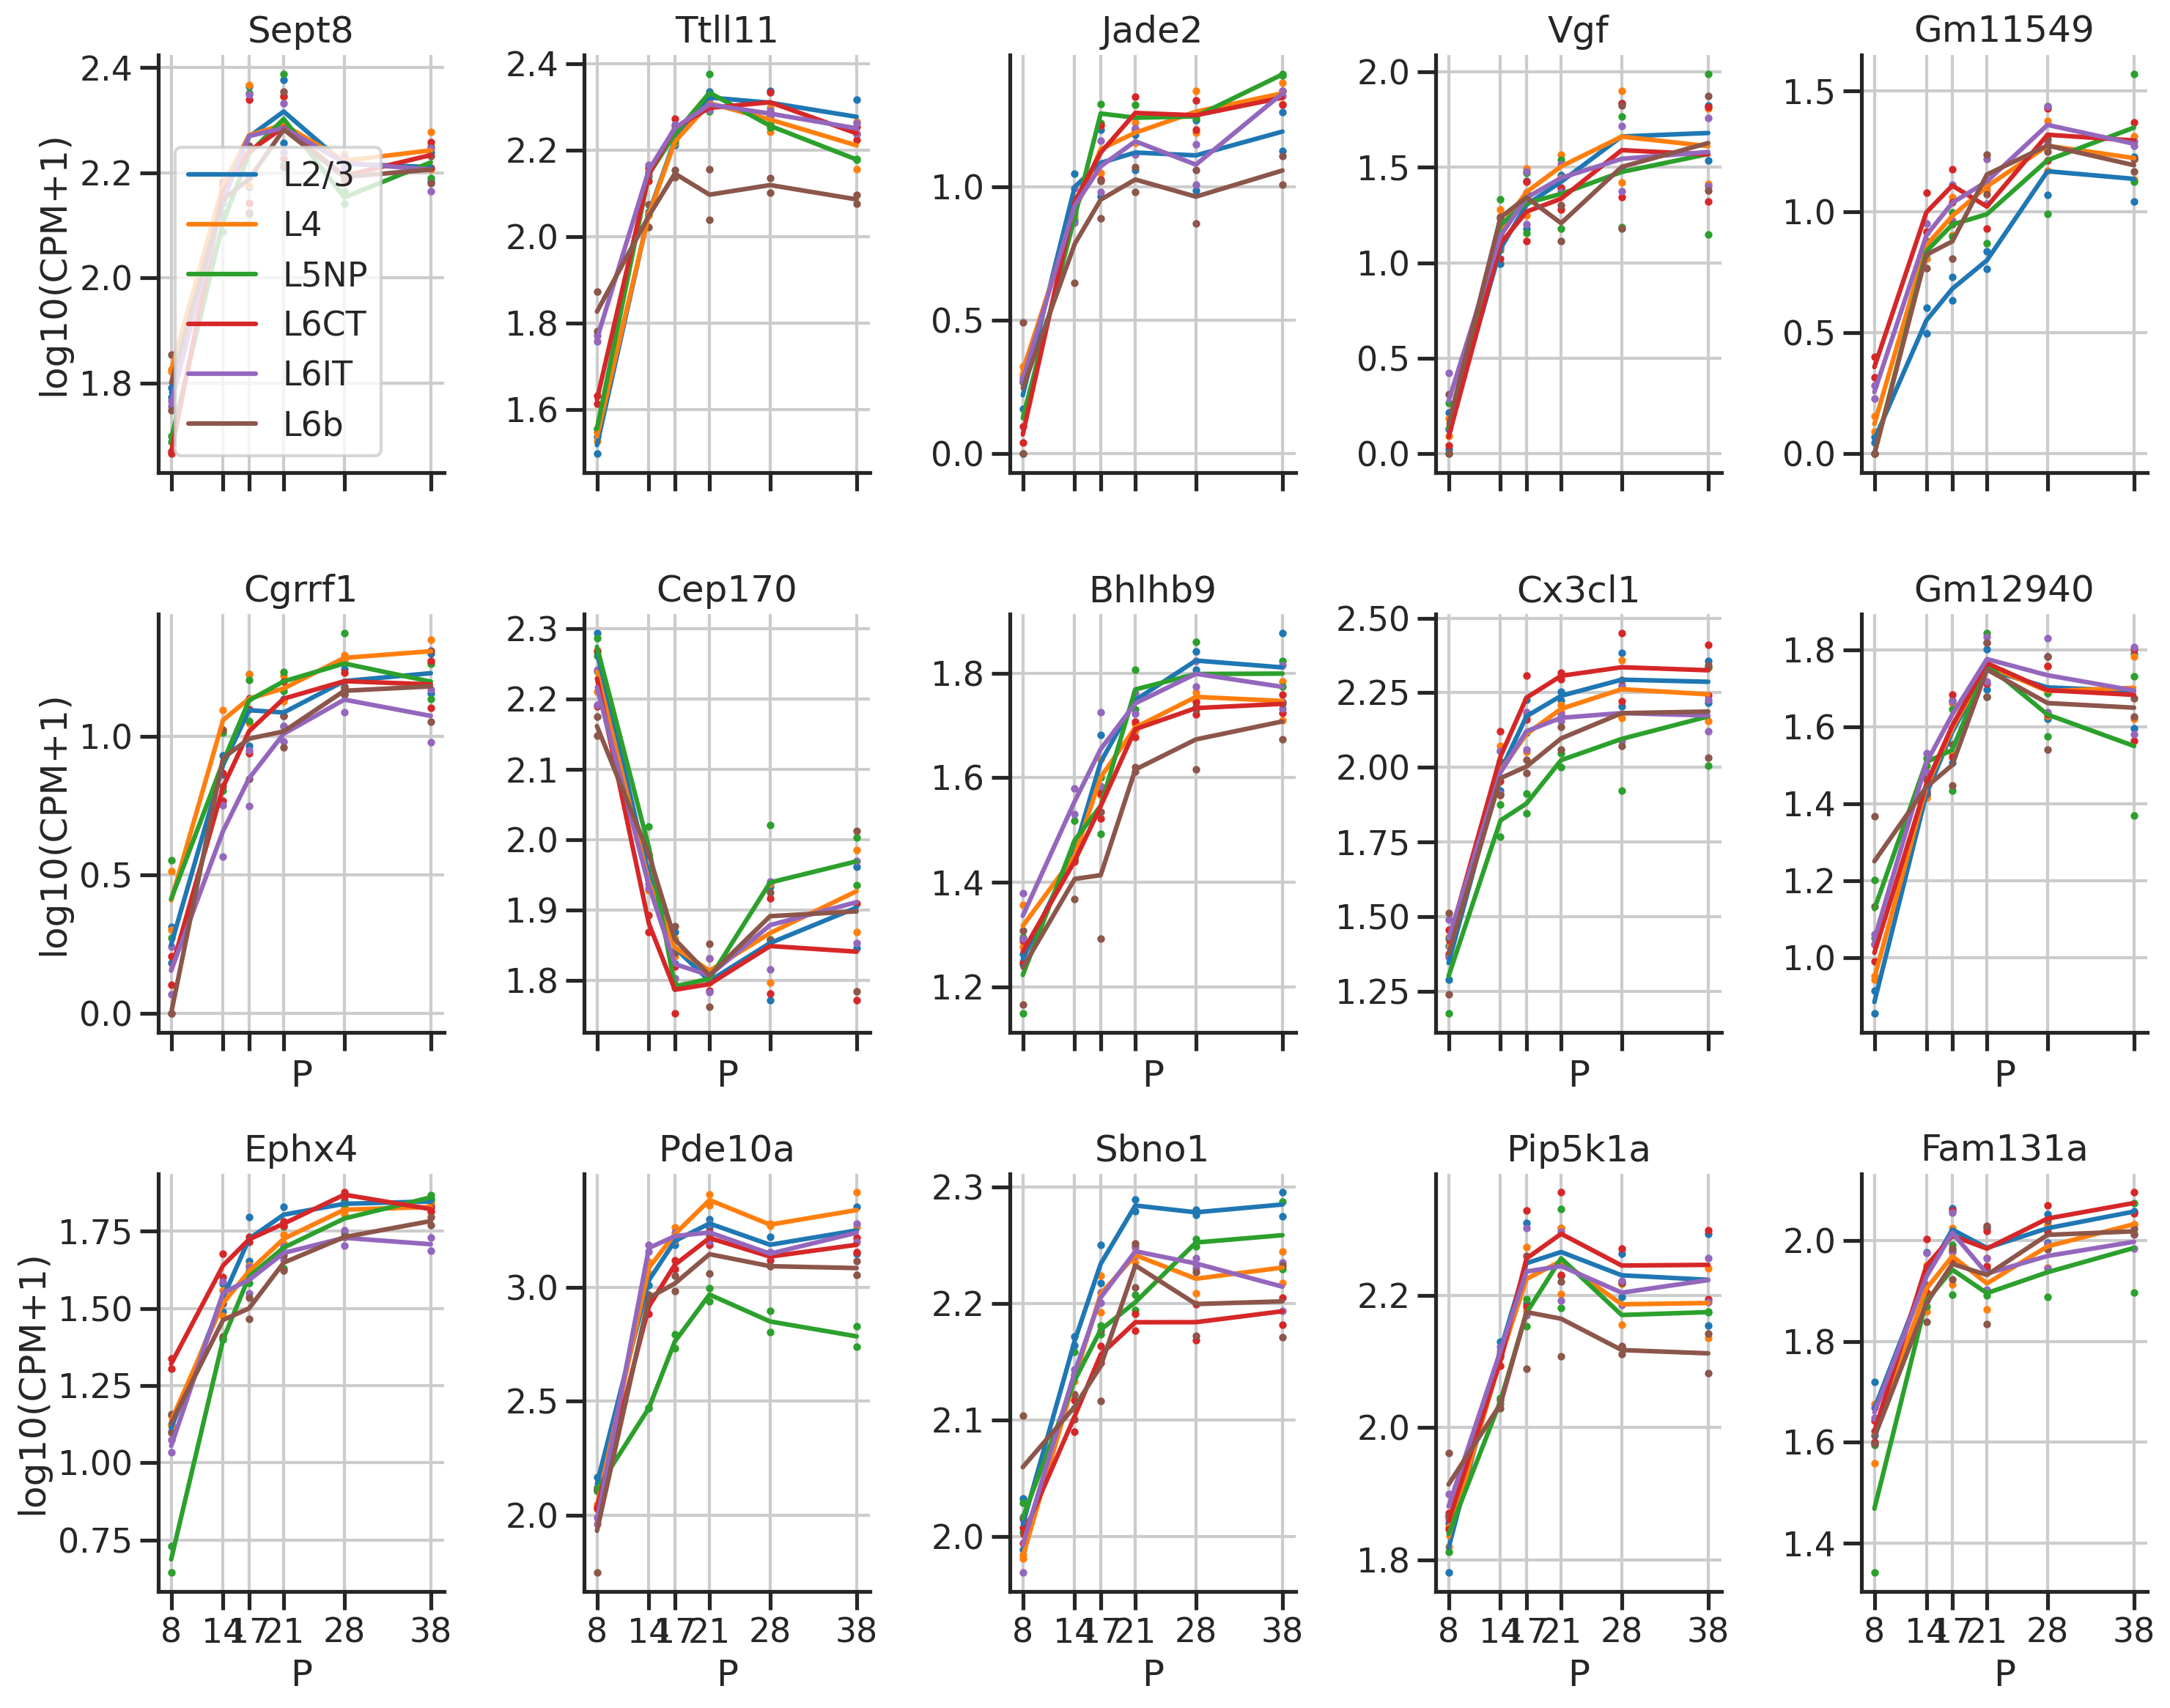

In [31]:
fig, axs = plt.subplots(3,5,figsize=(5*3,3*4), sharex=True)
for j, (pbulks_g, gname, ax) in enumerate(zip(pbulks_sub, gnames, axs.flat)):
    ax.set_title(gname)
    for i in range(nc):
        color = colors[i]
        lbl = types[i]
        ax.plot(ts, np.mean(pbulks_g[i], axis=0), color=color, label=lbl)
        ax.scatter(ts, pbulks_g[i][0], s=5, color=color)
        ax.scatter(ts, pbulks_g[i][1], s=5, color=color)
    ax.set_xticks(ts)
    sns.despine(ax=ax)
    if j == 0:
        ax.legend()
    if j % 5 == 0:
        ax.set_ylabel('log10(CPM+1)')
    if j >= 5:
        ax.set_xlabel('P')
    
fig.tight_layout()
plt.show()

In [32]:
cond = np.logical_and(eta2_t+eta2_c>0.8, np.abs(eta2_t-0.5)<0.2)
cond = np.logical_and(cond, np.abs(eta2_c-0.5)<0.2)
gi_ct = np.arange(len(genes))[cond]
# gi_ct = np.array([g for g in gi_ct if (g not in gi_c and g not in gi_t)])
gi_ct.shape

(462,)

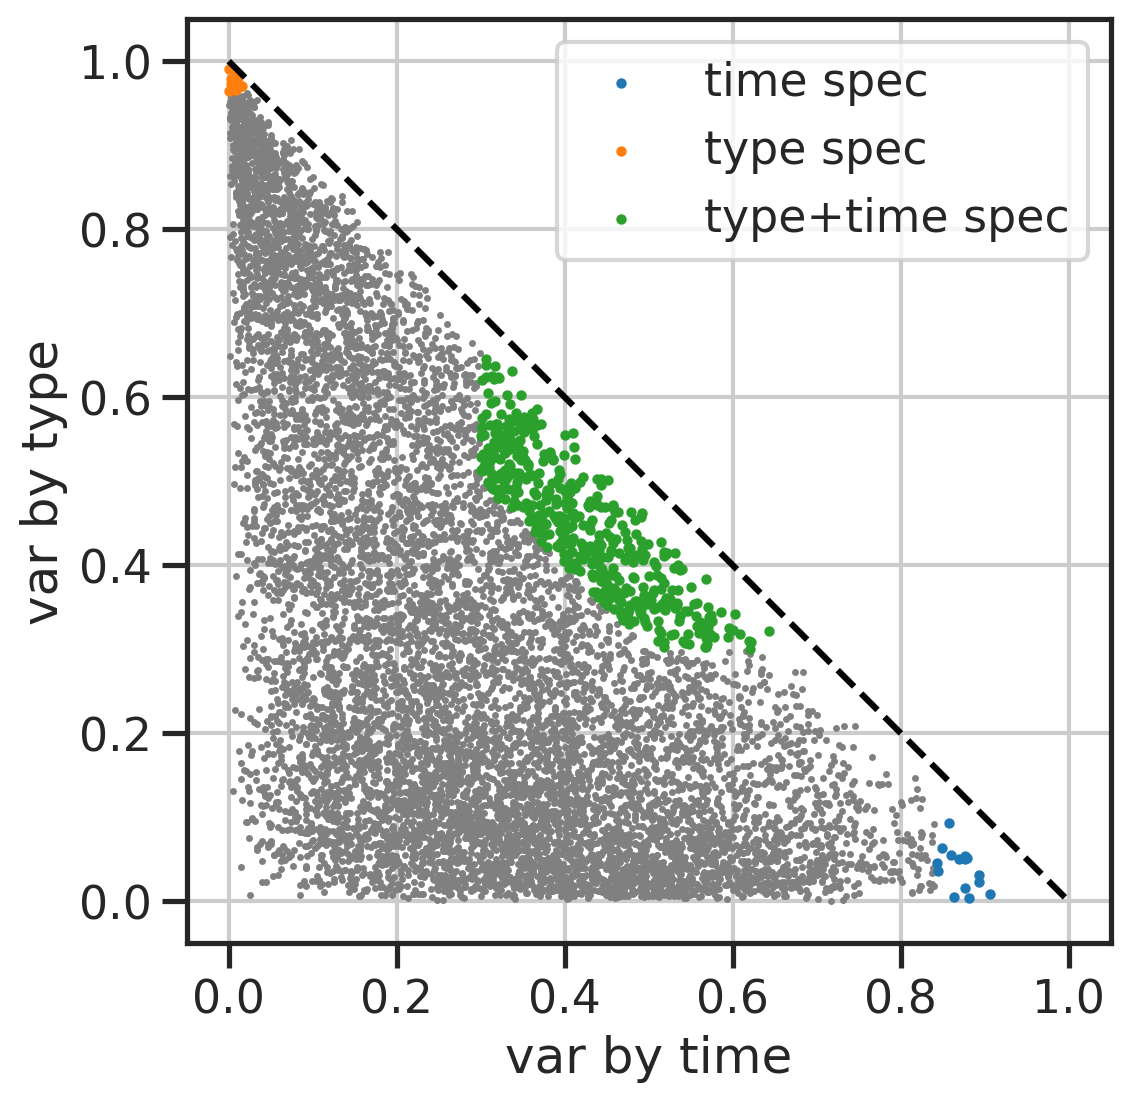

In [33]:
fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(eta2_t, eta2_c, s=1, color='gray')
ax.scatter(eta2_t[gi_t], eta2_c[gi_t], s=5, color='C0', label='time spec')
ax.scatter(eta2_t[gi_c], eta2_c[gi_c], s=5, color='C1', label='type spec')
ax.scatter(eta2_t[gi_ct], eta2_c[gi_ct], s=5, color='C2', label='type+time spec')
ax.set_aspect('equal')
ax.set_xlabel('var by time')
ax.set_ylabel('var by type')
ax.legend()
ax.plot([0,1], [1,0], color='k', linestyle='--')
plt.show()

In [34]:
pbulks_sub = pbulks[:,:,:,gi_ct]
pbulks_sub = np.swapaxes(pbulks_sub, 0, 3) # nt, nr, nc, ng -> ng, nc, nr, nt
pbulks_sub = np.swapaxes(pbulks_sub, 1, 2) # nt, nr, nc, ng -> ng, nc, nr, nt
gnames = genes[gi_ct]
print(pbulks_g.shape)

(6, 2, 6)


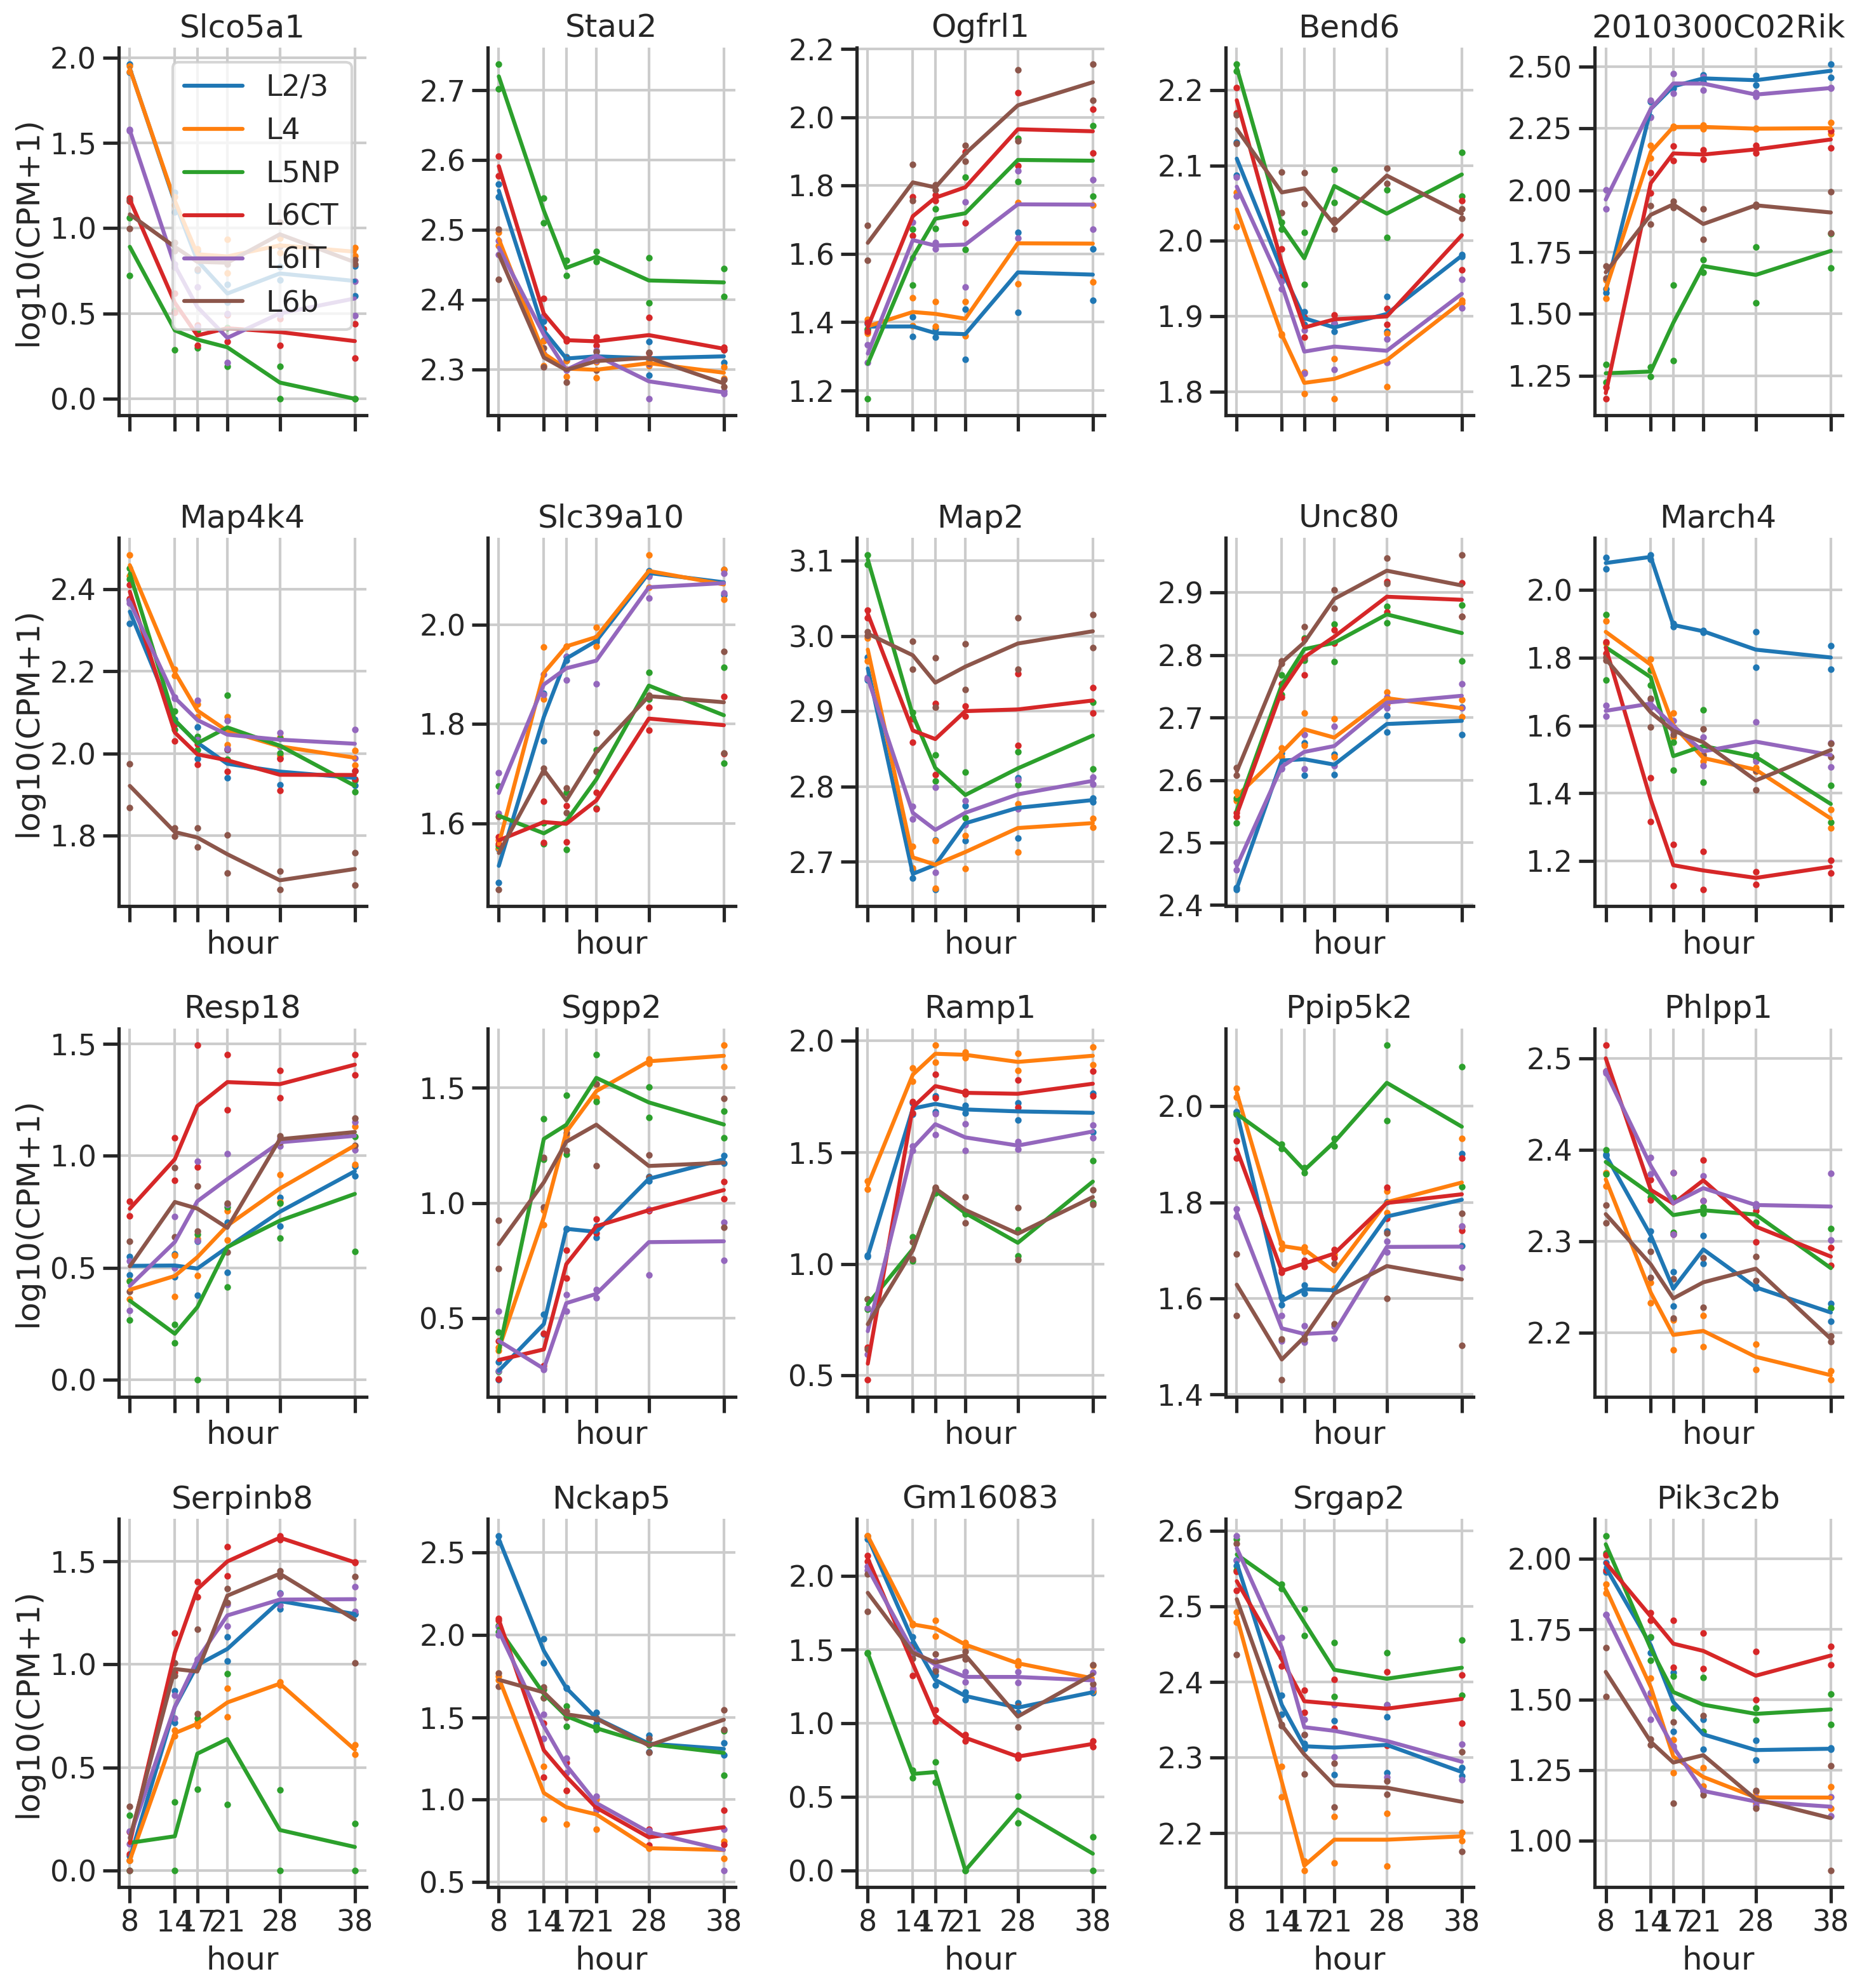

In [35]:
fig, axs = plt.subplots(4,5,figsize=(5*3,4*4), sharex=True)
for j, (pbulks_g, gname, ax) in enumerate(zip(pbulks_sub, gnames, axs.flat)):
    ax.set_title(gname)
    for i in range(nc):
        color = colors[i]
        lbl = types[i]
        ax.plot(ts, np.mean(pbulks_g[i], axis=0), color=color, label=lbl)
        ax.scatter(ts, pbulks_g[i][0], s=5, color=color)
        ax.scatter(ts, pbulks_g[i][1], s=5, color=color)
    ax.set_xticks(ts)
    sns.despine(ax=ax)
    if j == 0:
        ax.legend()
    if j % 5 == 0:
        ax.set_ylabel('log10(CPM+1)')
    if j >= 5:
        ax.set_xlabel('hour')
    
fig.tight_layout()
plt.show()

In [36]:
gi1 = basicu.get_index_from_array(genes, ['Slc17a7'])
gi2 = basicu.get_index_from_array(genes, ['Cux2'])
gi3 = basicu.get_index_from_array(genes, ['Cdh13'])

gi1, gi2, gi3

(array([4254]), array([3273]), array([5658]))

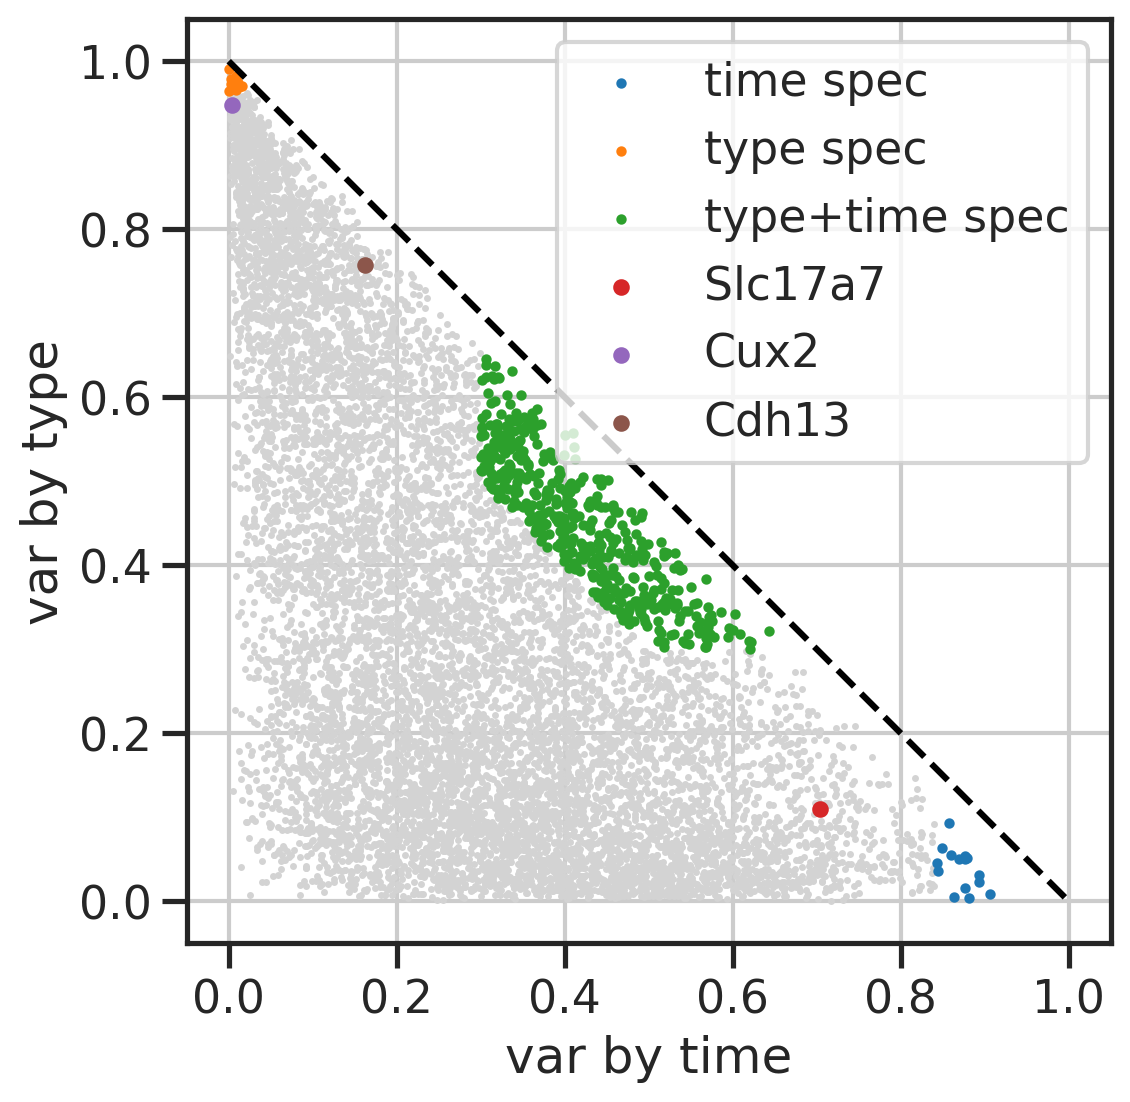

In [37]:
fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(eta2_t, eta2_c, s=1, color='lightgray')
ax.scatter(eta2_t[gi_t], eta2_c[gi_t], s=5, color='C0', label='time spec')
ax.scatter(eta2_t[gi_c], eta2_c[gi_c], s=5, color='C1', label='type spec')
ax.scatter(eta2_t[gi_ct], eta2_c[gi_ct], s=5, color='C2', label='type+time spec')
ax.scatter(eta2_t[gi1], eta2_c[gi1], s=20, color='C3', label='Slc17a7')
ax.scatter(eta2_t[gi2], eta2_c[gi2], s=20, color='C4', label='Cux2')
ax.scatter(eta2_t[gi3], eta2_c[gi3], s=20, color='C5', label='Cdh13')
ax.set_aspect('equal')
ax.set_xlabel('var by time')
ax.set_ylabel('var by type')
ax.legend()
ax.plot([0,1], [1,0], color='k', linestyle='--')
plt.show()

(1, 6, 2, 6)


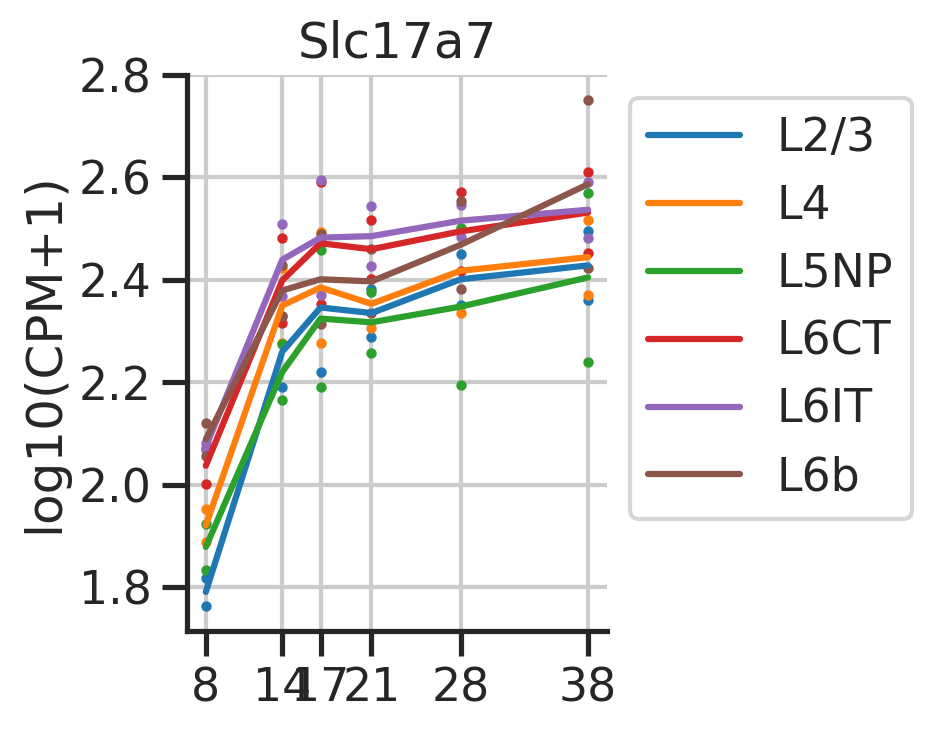

(1, 6, 2, 6)


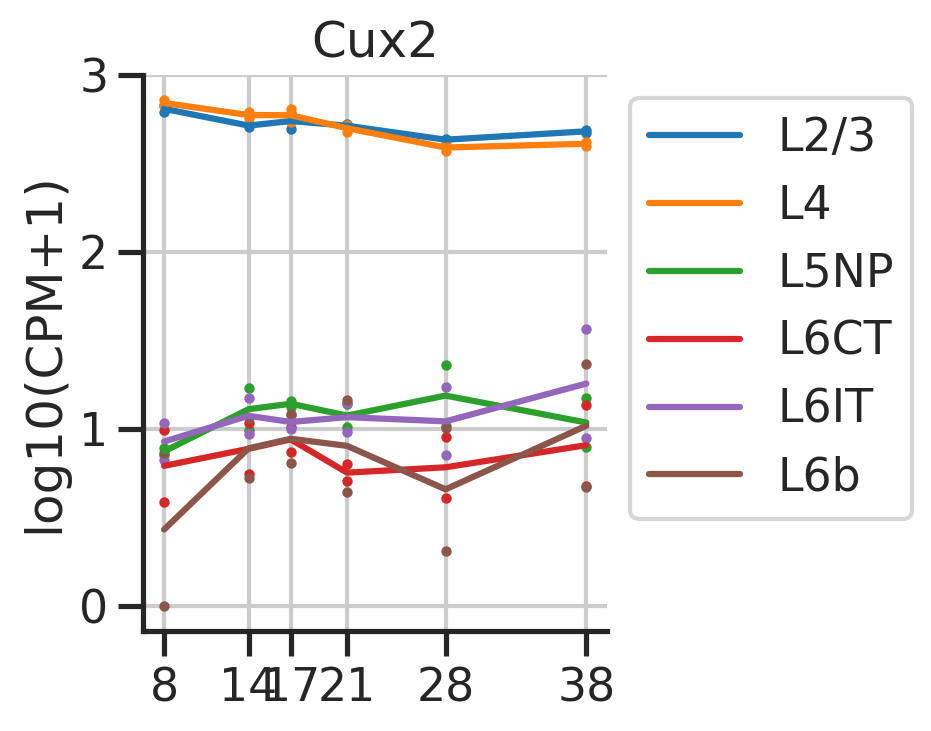

(1, 6, 2, 6)


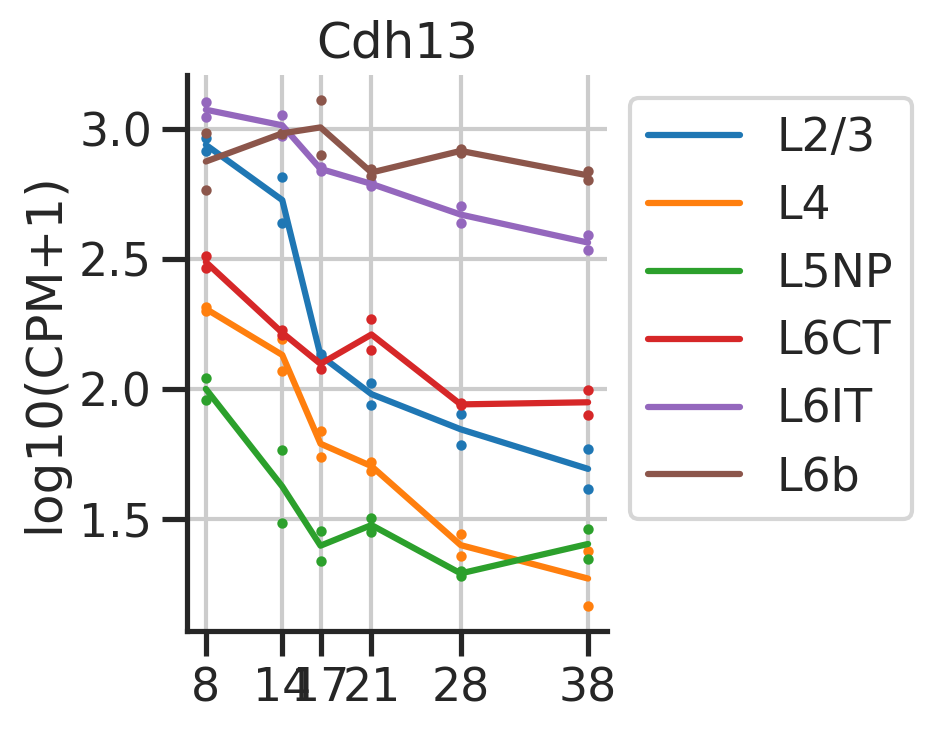

In [38]:
for gi in [gi1, gi2, gi3]:
    pbulks_sub = pbulks[:,:,:,gi] #, axis=3)
    pbulks_sub = np.swapaxes(pbulks_sub, 0, 3) # nt, nr, nc, ng -> ng, nc, nr, nt
    pbulks_sub = np.swapaxes(pbulks_sub, 1, 2) # nt, nr, nc, ng -> ng, nc, nr, nt
    gnames = genes[gi]
    print(pbulks_sub.shape)

    fig, axs = plt.subplots(1,1,figsize=(1*5,1*4), sharex=True)
    for j, (pbulks_g, gname, ax) in enumerate(zip(pbulks_sub, gnames, [axs])):
        ax.set_title(gname)
        for i in range(nc):
            color = colors[i]
            lbl = types[i]
            ax.plot(ts, np.mean(pbulks_g[i], axis=0), color=color, label=lbl)
            ax.scatter(ts, pbulks_g[i][0], s=5, color=color)
            ax.scatter(ts, pbulks_g[i][1], s=5, color=color)
        ax.set_xticks(ts)
        sns.despine(ax=ax)
        if j == 0:
            ax.legend(bbox_to_anchor=(1,1))
        if j % 5 == 0:
            ax.set_ylabel('log10(CPM+1)')
        if j >= 5:
            ax.set_xlabel('hour')

    fig.tight_layout()
    plt.show()

In [47]:
cond = np.logical_and(eta2_t+eta2_c<0.2, eta2_r<0.001)
gi_nct = np.arange(len(genes))[cond]
gi_nct.shape

(19,)

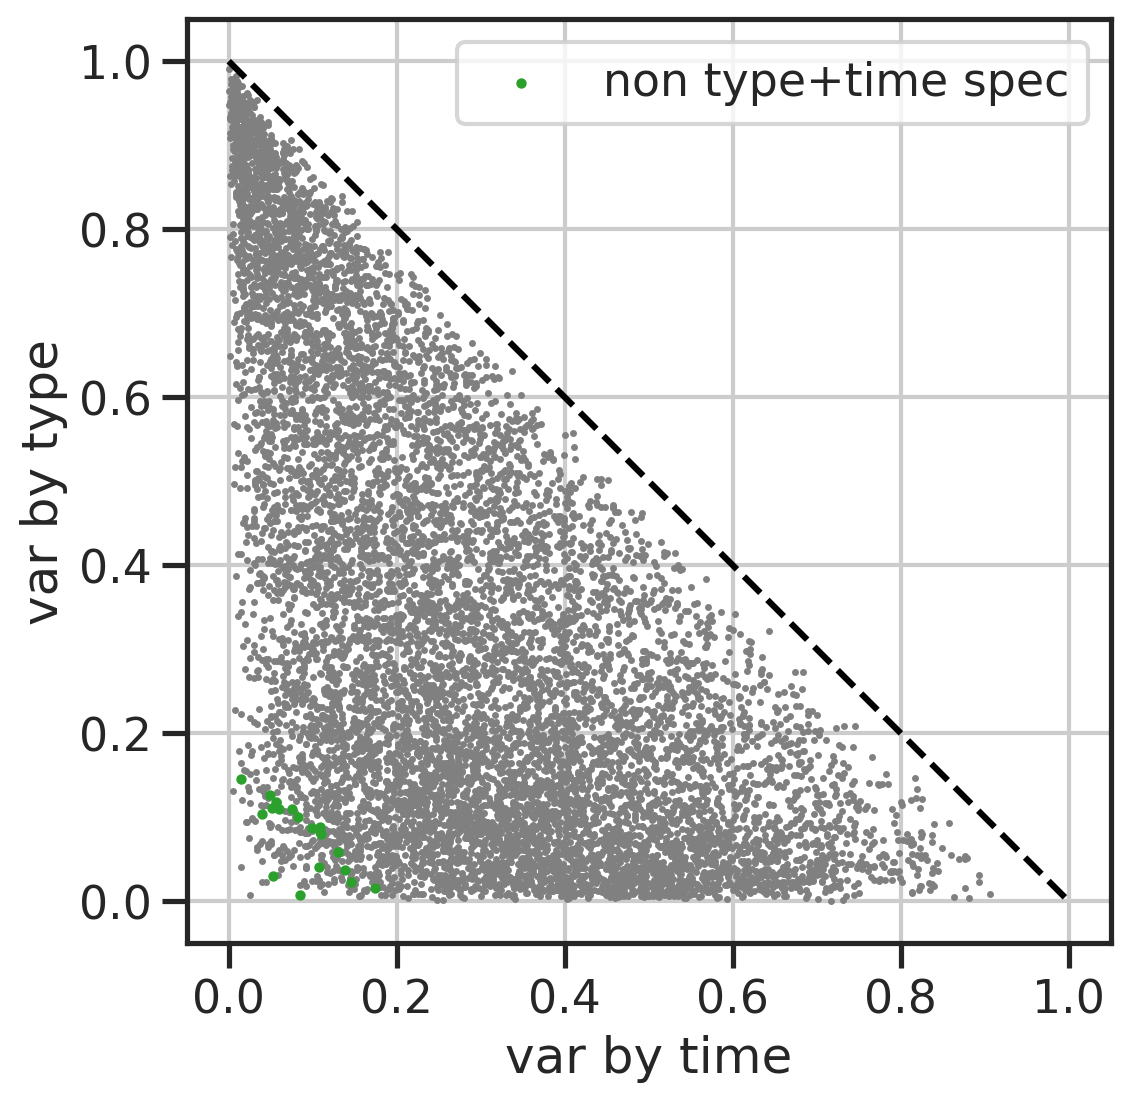

In [48]:
fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(eta2_t, eta2_c, s=1, color='gray')
ax.scatter(eta2_t[gi_nct], eta2_c[gi_nct], s=5, color='C2', label='non type+time spec')
ax.set_aspect('equal')
ax.set_xlabel('var by time')
ax.set_ylabel('var by type')
ax.legend()
ax.plot([0,1], [1,0], color='k', linestyle='--')
plt.show()

In [49]:
pbulks_sub = pbulks[:,:,:,gi_nct]
pbulks_sub = np.swapaxes(pbulks_sub, 0, 3) # nt, nr, nc, ng -> ng, nc, nr, nt
pbulks_sub = np.swapaxes(pbulks_sub, 1, 2) # nt, nr, nc, ng -> ng, nc, nr, nt
gnames = genes[gi_nct]
print(pbulks_g.shape)

(6, 2, 6)


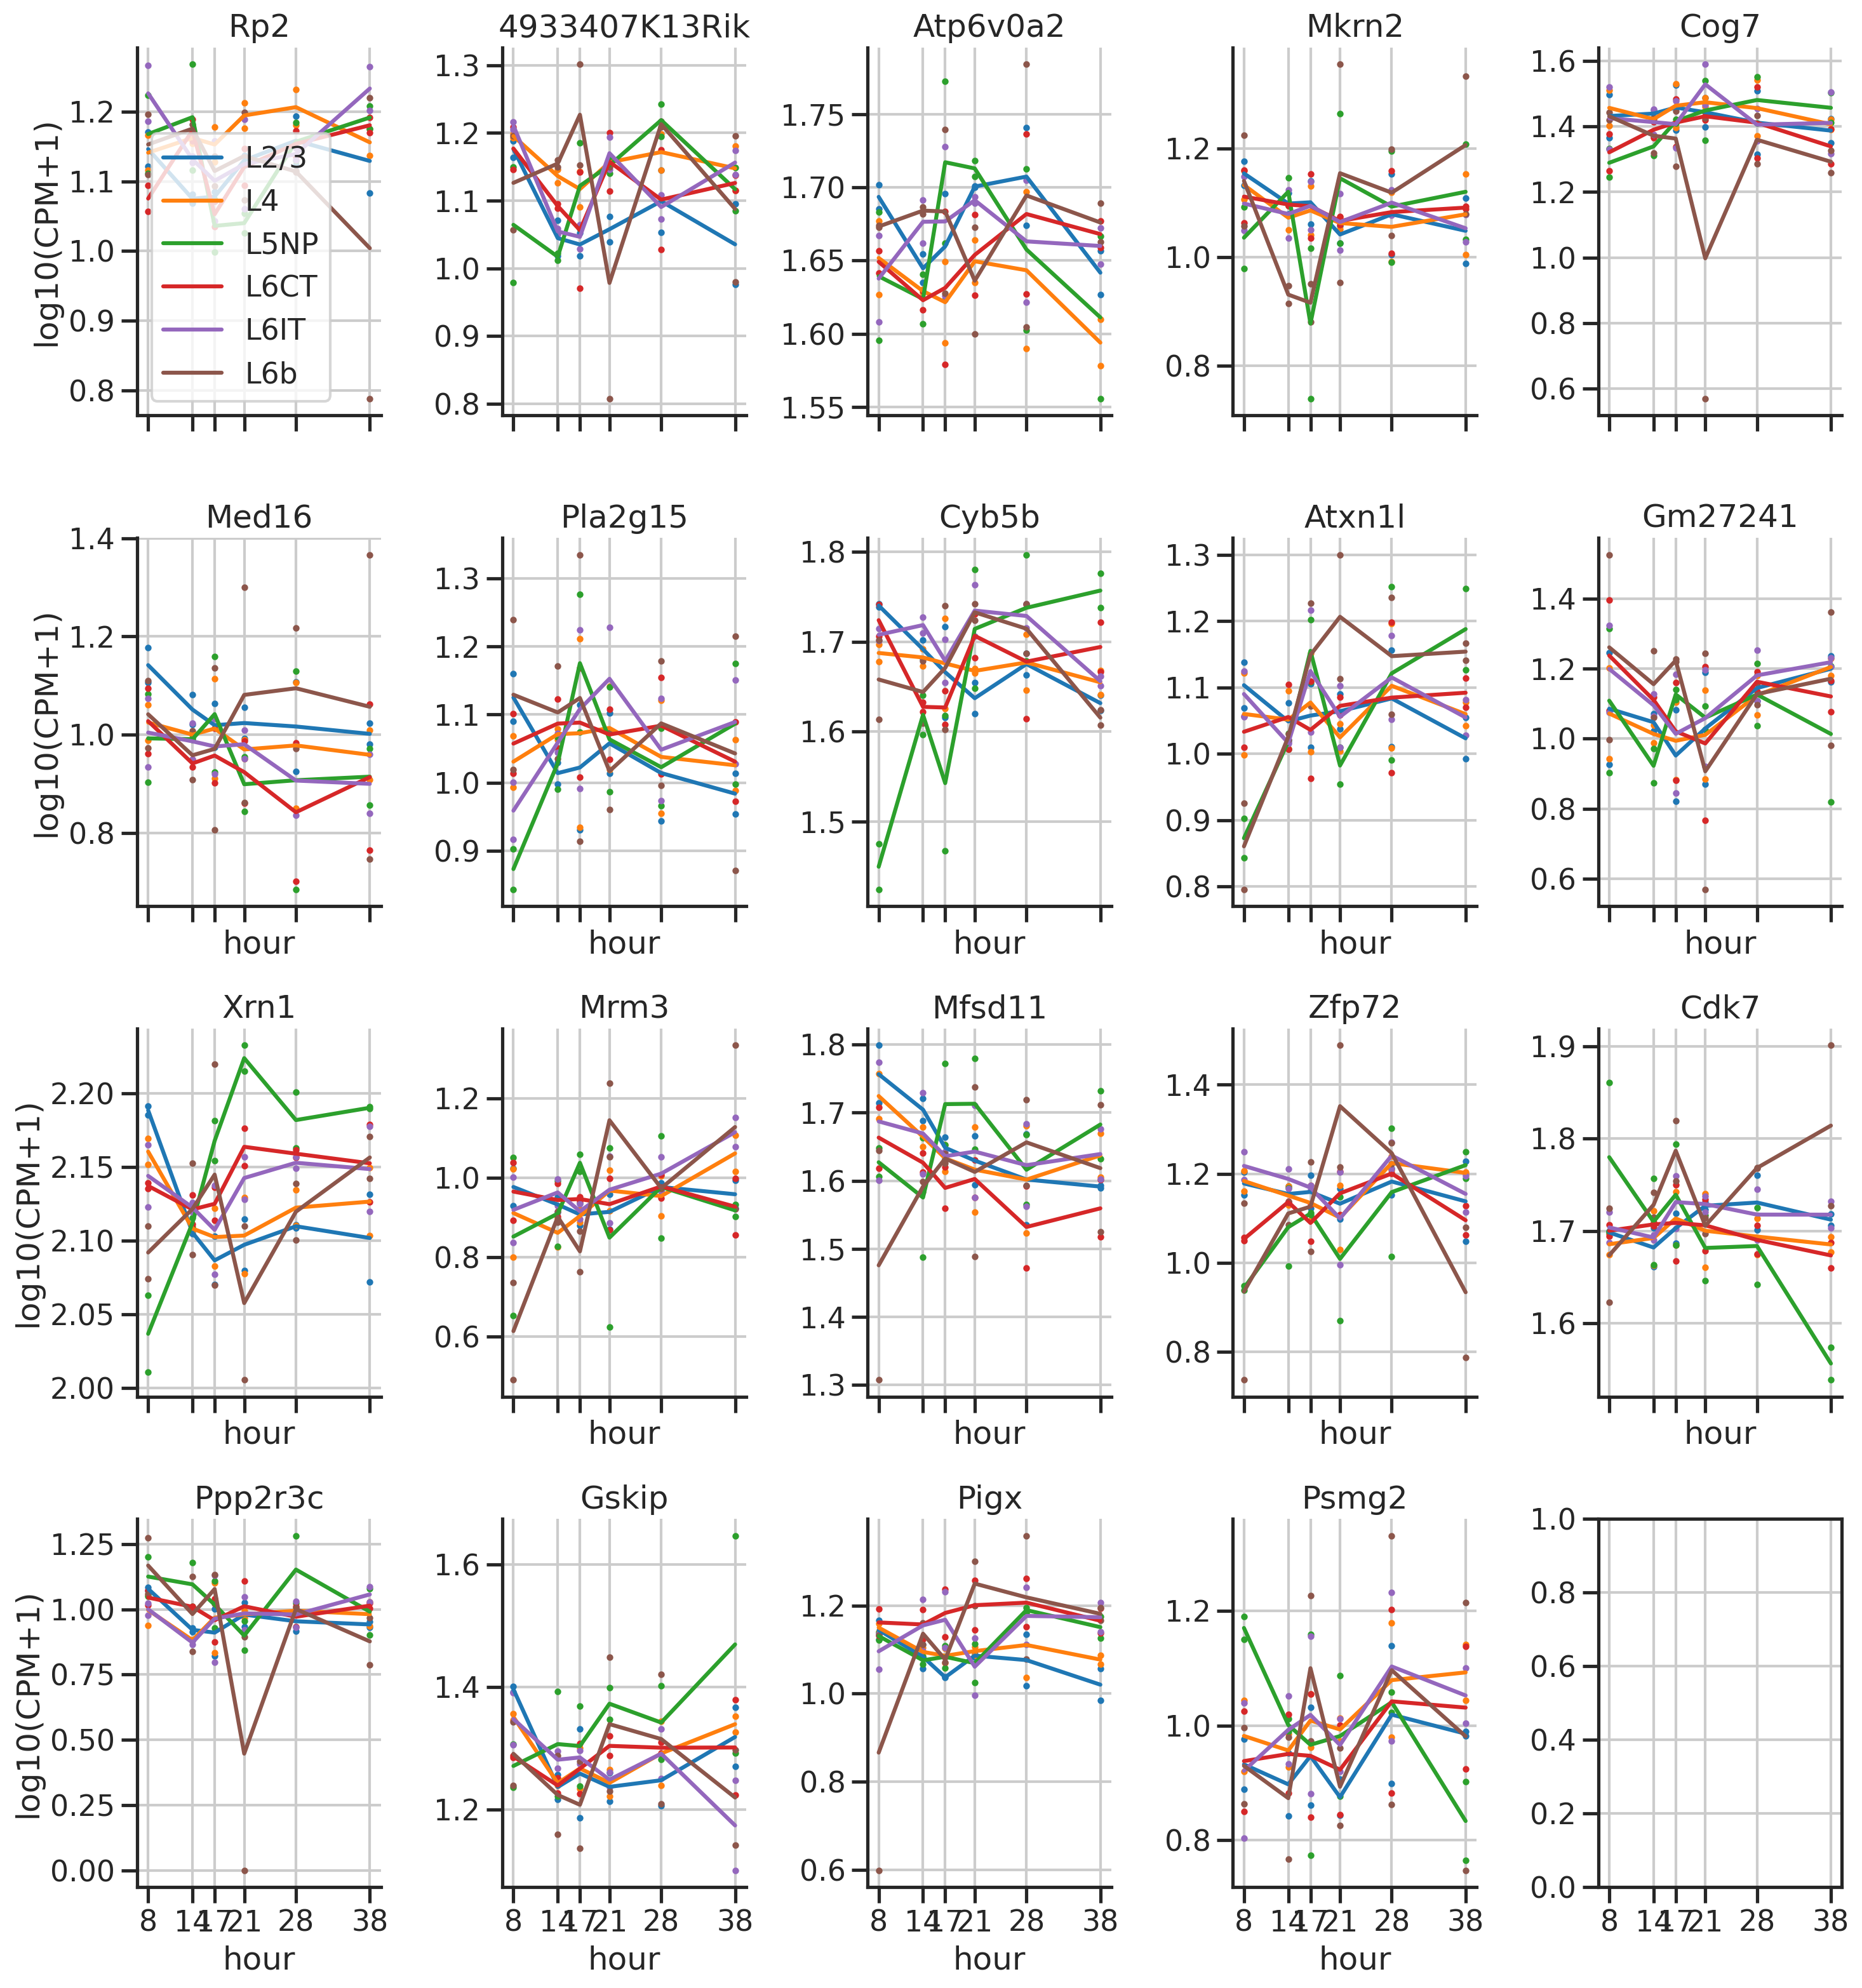

In [50]:
fig, axs = plt.subplots(4,5,figsize=(5*3,4*4), sharex=True)
for j, (pbulks_g, gname, ax) in enumerate(zip(pbulks_sub, gnames, axs.flat)):
    ax.set_title(gname)
    for i in range(nc):
        color = colors[i]
        lbl = types[i]
        ax.plot(ts, np.mean(pbulks_g[i], axis=0), color=color, label=lbl)
        ax.scatter(ts, pbulks_g[i][0], s=5, color=color)
        ax.scatter(ts, pbulks_g[i][1], s=5, color=color)
    ax.set_xticks(ts)
    sns.despine(ax=ax)
    if j == 0:
        ax.legend()
    if j % 5 == 0:
        ax.set_ylabel('log10(CPM+1)')
    if j >= 5:
        ax.set_xlabel('hour')
    
fig.tight_layout()
plt.show()